In [62]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import contextily as ctx

from sklearn.linear_model import LinearRegression

In [61]:
DATA_DIR = "../datasets_full"
LONDON_BOROUGH_SHAPES = "./statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"

In [3]:
ug_activity = pd.read_csv(os.path.join(DATA_DIR, 'London', 'london_underground_activity.csv'))

In [4]:
ug_activity.head()

,year,nlc,station,area,weekday_entry,weekday_exit,saturday_entry,saturday_exit,sunday_entry,sunday_exit,annual_entry_and_exit
0,2007,500,Acton Town,Ealing,9205,8899.0,6722,6320,4427,4304,5.77
1,2007,502,Aldgate,City of London,9887,10397.0,2191,2587,1484,1772,5.57
2,2007,503,Aldgate East,Tower Hamlets,12820,12271.0,7040,6220,5505,5000,7.66
3,2007,505,Alperton,Brent,4611,4719.0,3354,3450,2433,2503,3.01
4,2007,506,Amersham,Chiltern,4182,3938.0,1709,1585,1004,957,2.34


In [5]:
area_annual_act = ug_activity.pivot_table(index='area', columns='year', values='annual_entry_and_exit', aggfunc=np.sum)

In [6]:
area_annual_act.head()

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
area,,,,,,,,,,,
Barking and Dagenham,22.77,22.29,23.74,24.41,25.76,26.68,28.14,29.98,31.154386,31.15,33.62
Barnet,44.58,47.17,48.18,49.51,51.37,50.31,50.43,56.07,59.198246,61.25,63.56
Brent,79.77,79.75,77.18,74.68,78.07,81.43,84.65,90.88,94.158019,96.47,98.09
Camden,237.24,243.57,245.91,255.75,267.96,275.81,285.25,304.79,315.279853,309.28,308.83
Chiltern,4.08,3.81,3.63,3.67,3.91,4.02,3.84,4.73,4.599944,4.92,5.12


In [7]:
before_olympics = area_annual_act.loc[:, :2012]
after_olympics = area_annual_act.loc[:, 2012:]

In [8]:
def get_slope(series):
    regressor = LinearRegression()
    
    indices = series.index.to_numpy().reshape(-1, 1)
    regressor.fit(indices, series)
    
    return regressor.coef_[0]

In [9]:
before_slopes = before_olympics.apply(get_slope, axis=1)
after_slopes = after_olympics.apply(get_slope, axis=1)

before_slopes = before_slopes.rename('before')
after_slopes = after_slopes.rename('after')

In [10]:
slopes = pd.concat([before_slopes, after_slopes], axis=1)

slopes['diff'] = (slopes['after'] - slopes['before']) / area_annual_act.mean(axis=1)

In [11]:
area_annual_act.index

Index(['Barking and Dagenham', 'Barnet', 'Brent', 'Camden', 'Chiltern',
       'City of London', 'City of Westminster', 'Ealing', 'Enfield',
       'Epping Forest', 'Greenwich', 'Hackney', 'Hammersmith and Fulham',
       'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Lambeth', 'Merton', 'Newham', 'Redbridge',
       'Richmond', 'Southwark', 'Three Rivers', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Watford'],
      dtype='object', name='area')

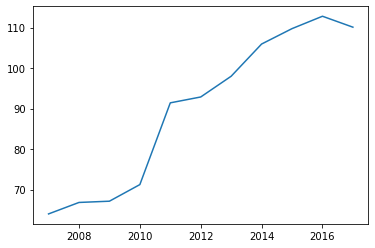

In [12]:
plt.plot(area_annual_act.loc['Newham'])

In [13]:
slopes.loc['Newham']

before    6.349143
after     3.839561
diff     -0.027882
Name: Newham, dtype: float64

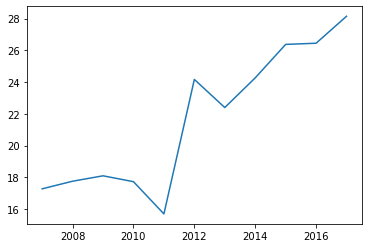

In [14]:
plt.plot(area_annual_act.loc['Greenwich'])

In [15]:
slopes.loc['Greenwich']

before    0.797143
after     0.975916
diff      0.008249
Name: Greenwich, dtype: float64

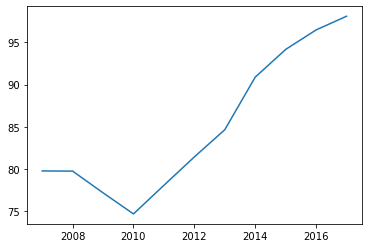

In [16]:
plt.plot(area_annual_act.loc['Brent'])

In [17]:
slopes.loc['Brent']

before    0.021714
after     3.486801
diff      0.040760
Name: Brent, dtype: float64

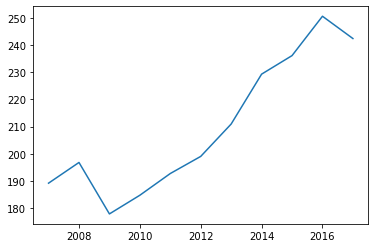

In [18]:
plt.plot(area_annual_act.loc['City of London'])

In [37]:
slopes.loc['City of London']

before    1.254571
after     9.787711
diff      0.040638
Name: City of London, dtype: float64

In [64]:
map_df = gpd.read_file(LONDON_BOROUGH_SHAPES)
map_df = map_df.to_crs('epsg:3857')

In [65]:
map_df.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((-36811.020 6679699.611, -36801.601 6..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((-7126.807 6677851.759, -7132.828 667..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((1350.415 6674461.413, 1331.568 66744..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((-27224.557 6708199.030, -27237.660 6..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((-45845.001 6716316.317, -45850.623 6..."


In [66]:
locations = pd.DataFrame({
    'Name': ['Olympic Park'],
    'Latitude': [51.54615],
    'Longitude': [-0.01269]
})

In [67]:
geo_locs = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude), crs="EPSG:4326")

In [68]:
geo_locs = geo_locs.to_crs('epsg:3857')

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


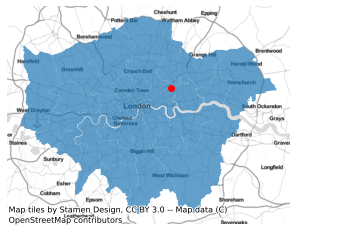

In [79]:
ax = map_df.plot(alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend="bottomright")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [80]:
merged = map_df.set_index('NAME').join(area_annual_act)

In [81]:
merged[2012]

NAME
Kingston upon Thames         NaN
Croydon                      NaN
Bromley                      NaN
Hounslow                   24.05
Ealing                     61.62
Havering                   10.32
Hillingdon                 40.29
Harrow                     29.96
Brent                      81.43
Barnet                     50.31
Lambeth                   169.14
Southwark                 125.25
Lewisham                     NaN
Greenwich                  24.17
Bexley                       NaN
Enfield                    13.26
Waltham Forest             45.35
Redbridge                  31.81
Sutton                       NaN
Richmond upon Thames         NaN
Merton                     30.72
Wandsworth                 50.70
Hammersmith and Fulham    117.25
Kensington and Chelsea    152.85
Westminster                  NaN
Camden                    275.81
Tower Hamlets             135.36
Islington                 130.86
Hackney                     9.23
Haringey                   54.68
Newha

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  This is separate from the ipykernel package so we can avoid doing imports until


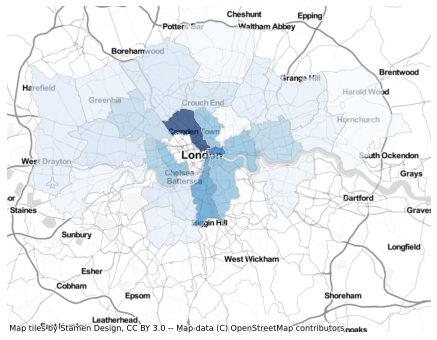

In [84]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged.plot(column=2017, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.7)
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

In [86]:
merged_diffs = map_df.set_index('NAME').join(slopes)

/Users/edwardli/anaconda3/envs/datathon/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  after removing the cwd from sys.path.


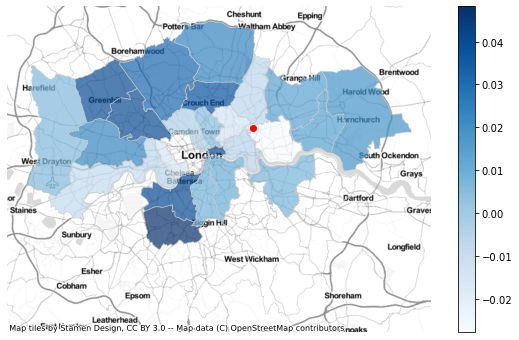

In [88]:
fig, ax = plt.subplots(1, figsize=(10, 6))
merged_diffs.plot(column='diff', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend='bottomright', alpha=0.7)
geo_locs.plot(ax=ax, color='red', label="test", legend="bottomright")
ctx.add_basemap(ax, zoom=10, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.savefig('test.png')